<a href="https://colab.research.google.com/github/RISHABH084/Kaggle-Challenges/blob/master/HousePrice_prediction_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [0]:
! mkdir ~/.kaggle.
!cp kaggle.json ~/.kaggle/

In [6]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 51.6MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 61.3MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 63.9MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 12.3MB/s]


In [0]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

from scipy.special import boxcox1p
from scipy.stats import skew

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [0]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')


In [11]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [13]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# A quick look at data
train.head().T

,0,1,2,3,4
Id,1,2,3,4,5
MSSubClass,60,20,60,70,60
MSZoning,RL,RL,RL,RL,RL
LotFrontage,65,80,68,60,84
LotArea,8450,9600,11250,9550,14260
Street,Pave,Pave,Pave,Pave,Pave
Alley,NaN,NaN,NaN,NaN,NaN
LotShape,Reg,Reg,IR1,IR1,IR1
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub


Steps for EDA :

1.   Examine Data
2.   Univariate study 
3.   Multivariate study
4.   Data Cleaning
5.   Assumption or filling the values





*   Referrred from Kaggle : Data Exploration is just like going to party. If we talk in terms of women analogy the reason for going to party is to find a company of pretty women  
*   Sales Price is similarly a target variable which we want to approach 
*   'Hi, I'm Kaggly! And you? 'SalePrice'? What a beautiful name! You know 'SalePrice', could you give me some data about you? I just developed a model to calculate the probability of a successful relationship between two people. I'd like to apply it to us!'





In [14]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

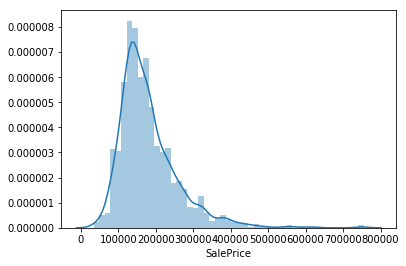

In [20]:
# Lets check out the figure and shape of Miss SalePrice
import seaborn as sns
sns.distplot(train['SalePrice'])
